In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import glob
import os

In [2]:
def data_and_labels(path):
    
    image_list = []
    for filename in glob.glob(path + '*.gif'):
        im=Image.open(filename)
        image_list.append(im)
    
    data = [0]*len(image_list)
    for i,image in enumerate(image_list):
        data[i] = np.array(image)
    
    data = np.array(data) # Contains the image data as numpy array
    N, D = data.shape[0], data.shape[1]
    data = data.reshape(N,D*D)
    names = os.listdir(path)
    labels = []
    
    #### 1: Happy
    #### 0: Sad
    
    for name in names:
        if 'happy' in name:
            labels.append(1) 
        elif 'sad' in name:
            labels.append(0)
        
    labels = np.array(labels) # Contains the class labels as numpy array
        
    return data, labels

In [3]:
path = 'emotion_classification/train/'
train_data, train_labels = data_and_labels(path)

path = 'emotion_classification/test/'    
test_data, test_labels = data_and_labels(path)

In [4]:
# Data prep

scaling = StandardScaler()
scaling.fit(train_data)
X_scaled = scaling.transform(train_data)  # Normalizing data

principal = PCA(n_components = 12)  
principal.fit(X_scaled)
X = principal.transform(X_scaled)  # Applying PCA

# Applying learnt transformations on test data
test_data = scaling.transform(test_data)
test_data = principal.transform(test_data)

### Helper Functions

In [5]:
def softmax(vector):
    ee = np.exp(vector)
    return ee / ee.sum()

def relu(x): # Vectorized
    z = x.shape[0]
    ans = np.zeros(z)
    for i in range(z):
        ans[i] = np.maximum(x[i], 0)
    return ans

# Entropy function with softmax as hypothesis
def loss(y,y_ohe):
    return -np.mean(y_ohe*np.log(y))

### Internal Helper Functions

In [6]:
np.random.seed(1) # To give out same set of randomized outputs in each run

def initialize(archi):  # Random for W, zero for b
    w1 = np.random.randn(archi[0],archi[1])*0.1  # 0.1 had to be multiplied to the weights as the original ones gave large bias
    b1 = np.zeros(archi[1])
    w2 = np.random.randn(archi[1],archi[2])*0.1
    b2 = np.zeros(archi[2])
    return w1,b1,w2,b2

# One Hot Encoding
def binary_encoder(labs):
    y_ohe = []
    for lab in labs:
        if (lab==0):
            y_ohe.append([1,0])
        elif(lab == 1):
            y_ohe.append([0,1])

    return np.array(y_ohe)

### Neural Network Operations

In [7]:
def forward(x,w1,b1,w2,b2):  # Forward propagation
    a1 = np.dot(x,w1) + b1
    y1 = relu(a1)
    a2 = np.dot(y1,w2) +  b2
    y2 = softmax(a2)
    return y2,y1,a1
    

def update_all(a1,y1,y2,y_ohe,x,w2,b2,w1,b1,alpha):  # Backpropagation and updating combined in one function
    del2 = y2-y_ohe
    dw2 = y1.reshape(model[1],1)@del2.reshape(1,2)
    db2 = np.sum(del2)
  

    # Update setting for w1 and b1
    del1 = np.multiply((w2@del2.T).flatten(),np.where(a1 > 0, 1, 0)) 
    dw1 = x.reshape(12,1)@del1.reshape(1,model[1])
    db1 = np.sum(del1)
    
    # Updating all                      
    w2 = w2 - alpha*dw2
    b2 = b2 - alpha*db2
    w1 = w1 - alpha*dw1
    b1 = b1 - alpha*db1
    
    return w1,b1,w2,b2
    

### Train & Predict Functions

In [8]:
def train(X,train_labels,model,alpha):
    w1,b1,w2,b2 = initialize(model)
    y_ohe = binary_encoder(train_labels)
    
    l = []

    for _ in range(20):
        y2_holder = []

        for i,x in enumerate(X):
            y2,y1,a1 = forward(x,w1,b1,w2,b2)
            y2_holder.append(y2)
            w1,b1,w2,b2 = update_all(a1,y1,y2,y_ohe[i],x,w2,b2,w1,b1,alpha)


        l.append(loss(np.array(y2_holder),y_ohe))
    
    plt.figure(figsize = (7,7))
    plt.plot(l)
    plt.title("Convergence Plot")
    plt.xlabel("# Epochs")
    plt.ylabel("Loss Value")
    plt.grid()
    plt.show()
    print("FINAL LOSS = ",l[-1])
    return w1,b1,w2,b2

def predict(test_data,test_labels):
    y_hat = np.zeros(test_data.shape[0])

    for i in range(len(test_data)):
        ans = forward(test_data[i],w1,b1,w2,b2)[0]
        y_hat[i] = np.argmax(ans)
    
    acc = (np.sum(y_hat==test_labels)/len(test_labels))*100
    
    return acc
    

## TRAINING & TESTING WITH GIVEN MODELS

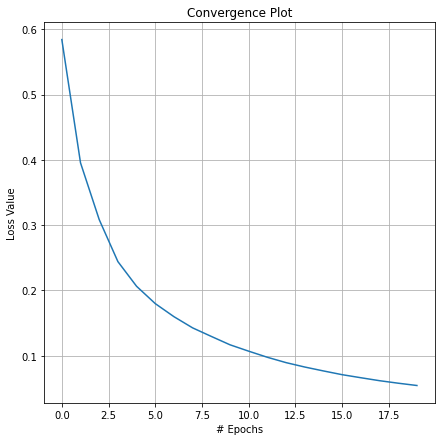

FINAL LOSS =  0.054329454545715306
TRAIN ACCURACY =  100.0 %
TEST ACCURACY =  90.0 %


In [9]:
model = [12,10,2]
alpha = 0.001  # This value of alpha worked best for the data
w1,b1,w2,b2 = train(X,train_labels,model,alpha)
acc = predict(X,train_labels)
print("TRAIN ACCURACY = ",acc,'%')
acc = predict(test_data,test_labels)
print("TEST ACCURACY = ",acc,'%')

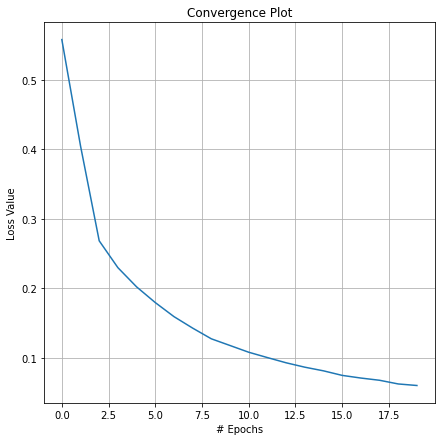

FINAL LOSS =  0.0604057292106364
TRAIN ACCURACY =  100.0 %
TEST ACCURACY =  70.0 %


In [10]:
model = [12,15,2]
alpha = 0.001  # Keeping alpha same as before for comparative test
w1,b1,w2,b2 = train(X,train_labels,model,alpha)
acc = predict(X,train_labels)
print("TRAIN ACCURACY = ",acc,'%')
acc = predict(test_data,test_labels)
print("TEST ACCURACY = ",acc,'%')

### On increasing the number of neurons to 15, the model gets less precise as evident by the drop in test accuracy. Also, the final value of loss increases by around 10%. This can be caused by a possible underfit as evident by the larger final loss value. More number of neurons might suggest a possible overfit but that is not as seen with the loss; i.e. overfitting is characterized by small training loss and obviously less test accuracy, but it is not the case. Underfitting on the other hand would result in large values of loss and less test accuracy. This underfitting can be based on the fact that number of epochs are very low and also attributed to the data itself.